# Rules extractor

Use this notebook to extract low-level rules from the game (ie: create low level tiles).

In [13]:
import numpy as np
import os
import xml.etree.ElementTree as ET

from pcgsepy.common.vecs import Orientation, orientation_from_vec, Vec
from pcgsepy.xml_conversion import convert_xml_to_structure

In [14]:
BLUEPRINTS_DIR = 'tileset'

In [15]:
# quick way to load all available rules
if False:
    from pcgsepy.xml_conversion import extract_rule
    available_tiles = os.listdir(BLUEPRINTS_DIR)
    for tile in available_tiles:
        rule, dims = extract_rule(bp_dir=os.path.join(BLUEPRINTS_DIR, tile))
        print(f'----\n{tile} 1 {rule}')
        print({
            tile: {
                'dimensions': [dims[0], dims[1], dims[2]],
                'offset': 5
            }
        })

In [16]:
available_tiles = os.listdir(BLUEPRINTS_DIR)

print('Available tiles:')
for i, tile in enumerate(available_tiles):
    print(f"  {i+1}. {tile}")
t = int(input('Choose which tile to process (number): ')) - 1
assert t > -1 and t < len(available_tiles), f'Invalid tile index: {t}'
rule_name = input("Enter name of tile (leave blank to use folder's): ")
rule_name = rule_name if rule_name else available_tiles[t]

Available tiles:
  1. Cockpit
  2. CorridorSimple
  3. CorridorWall
  4. CorridorWithCargo
  5. CorridorWithGyroscopes
  6. CorridorWithLights
  7. CorridorWithReactors
  8. Thrusters
  9. YccwXintersection
  10. YccwXYccwZintersection
  11. YccwXYccwZYcwXintersection
  12. YccwXYccwZYcwXYcwZintersection
  13. YccwXYccwZYcwZintersection
  14. YccwXYcwXintersection
  15. YccwXYcwXYcwZintersection
  16. YccwXYcwZintersection
  17. YccwZintersection
  18. YccwZYcwXintersection
  19. YccwZYcwXYcwZintersection
  20. YccwZYcwZintersection
  21. YcwXintersection
  22. YcwXYcwZintersection
  23. YcwZintersection


Choose which tile to process (number):  3
Enter name of tile (leave blank to use folder's):  corridorwall


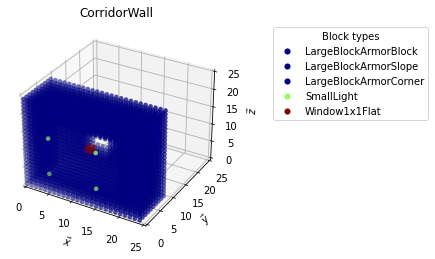

In [17]:
blueprint_directory = os.path.join(BLUEPRINTS_DIR, available_tiles[t])
bp = os.path.join(blueprint_directory, 'bp.sbc')

root = ET.parse(bp).getroot()
structure = convert_xml_to_structure(root_node=root)
structure.sanify()

structure.show(available_tiles[t])

blocks = structure.get_all_blocks()

In [18]:
max_x, max_y, max_z = 0., 0., 0.

for block in blocks:
    x, y, z = block.position.as_tuple()
    if x > max_x:
        max_x = x
    if y > max_y:
        max_y = y
    if z > max_z:
        max_z = z

In [19]:
min_x, min_y, min_z = max_x, max_y, max_z

for block in blocks:
    x, y, z = block.position.as_tuple()
    if x < min_x:
        min_x = x
    if y < min_y:
        min_y = y
    if z < min_z:
        min_z = z

In [20]:
for block in blocks:
    new_p = block.position.sum(Vec.v3f(-min_x, -min_y, -min_z))
    block.position = Vec.v3f(x=np.round(new_p.x, 1),
                             y=np.round(new_p.y, 1),
                             z=np.round(new_p.z, 1))

In [21]:
max_x -= min_x
max_y -= min_y
max_z -= min_z

In [22]:
def at_same_x(x, blocks):
    r = []
    for b in blocks:
        if b.position.x == x:
            r.append(b)
    return r


def at_same_y(y, blocks):
    r = []
    for b in blocks:
        if b.position.y == y:
            r.append(b)
    return r


def at_same_z(z, blocks):
    r = []
    for b in blocks:
        if b.position.z == z:
            r.append(b)
    return r

In [23]:
ordered_blocks = []
x, y, z = 0., 0., 0.
while z <= max_z:
    bs1 = at_same_z(z, blocks)
    while y <= max_y:
        bs2 = at_same_y(y, bs1)
        while x <= max_x:
            b = at_same_x(x, bs2)
            if b:
                ordered_blocks.append(b[0])
            x += 0.5
        x = 0.
        y += 0.5
    x = 0.
    y = 0.
    z += 0.5

In [24]:
orientations_str = {
    Orientation.FORWARD: 'F',
    Orientation.BACKWARD: 'B',
    Orientation.RIGHT: 'R',
    Orientation.LEFT: 'L',
    Orientation.UP: 'U',
    Orientation.DOWN: 'D',
}

In [25]:
rule = ''

x, y, z = 0., 0., 0.
for block in ordered_blocks:
    if block.position.z != z:
        if block.position.z > z:
            dz = block.position.z - z
            rule += f'<({int(dz // 0.5)})'
            z = block.position.z
        else:
            dz = z - block.position.z
            rule += f'>({int(dz // 0.5)})'
            z = block.position.z
    if block.position.y != y:
        if block.position.y > y:
            dy = block.position.y - y
            rule += f'!({int(dy // 0.5)})'
            y = block.position.y
        else:
            dy = y - block.position.y
            rule += f'?({int(dy // 0.5)})'
            y = block.position.y
    if block.position.x != x:
        if block.position.x > x:
            dx = block.position.x - x
            rule += f'+({int(dx // 0.5)})'
            x = block.position.x
        else:
            dx = x - block.position.x
            rule += f'-({int(dx // 0.5)})'
            x = block.position.x
    of = orientations_str[orientation_from_vec(block.orientation_forward)]
    ou = orientations_str[orientation_from_vec(block.orientation_up)]
    rule += f'{block.block_type}({of},{ou})'

if x != 0.:
    if x > 0.:
        rule += f'-({int(x // 0.5)})'
    if x < 0.:
        rule += f'+({int(-x // 0.5)})'
if y != 0.:
    if y > 0.:
        rule += f'?({int(y // 0.5)})'
    if y < 0.:
        rule += f'!({int(-y // 0.5)})'
if z != 0.:
    if z > 0.:
        rule += f'>({int(z // 0.5)})'
    if z < 0.:
        rule += f'<({int(-z // 0.5)})'

In [26]:
print(f'RULE: {rule_name}')
print(rule)
x, y, z = structure._max_dims
print(f'\nTILE DIMENSIONS: {x+5, y+5, z+5}')

RULE: corridorwall
LargeBlockArmorSlope(B,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(B,R)!(5)-(20)LargeBlockArmorCorner(D,F)+(5)LargeBlockArmorSlope(D,F)+(5)LargeBlockArmorSlope(D,F)+(5)LargeBlockArmorSlope(D,F)+(5)LargeBlockArmorCorner(D,R)<(5)?(5)-(20)LargeBlockArmorBlock(F,U)+(5)SmallLight(D,F)+(10)SmallLight(D,F)+(5)LargeBlockArmorBlock(F,U)!(5)-(20)LargeBlockArmorSlope(D,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(D,R)<(5)?(5)-(20)LargeBlockArmorBlock(F,U)+(20)LargeBlockArmorBlock(F,U)!(5)-(20)LargeBlockArmorSlope(D,L)+(5)LargeBlockArmorBlock(F,U)+(5)Window1x1Flat(B,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(D,R)<(5)?(5)-(20)LargeBlockArmorBlock(F,U)+(5)SmallLight(D,F)+(10)SmallLight(D,F)+(5)LargeBlockArmorBlock(F,U)!(5)-(20)LargeBlockArmorSlope(D,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBloc